In [369]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [370]:
# Download stock data for United Airlines. (UAL)
ticker = 'UAL'
start_date = '2005-01-01'
end_date = '2020-01-01'
data = yf.download(ticker, start=start_date, end=end_date, interval="1mo")


[*********************100%***********************]  1 of 1 completed


In [371]:
# Save the data to a CSV file

# filename = f'{ticker}_{start_date}_{end_date}.csv'
# df.to_csv(filename)

In [372]:
data = data[['Close']]
data = data.dropna()
data = data['Close'].resample('MS', label='left').mean()

Plotting the data

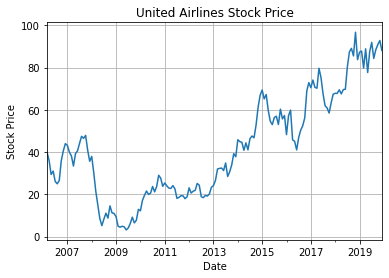

In [373]:
data.plot(title='United Airlines Stock Price', ylabel='Stock Price')
plt.grid()

Splitting the data into training and test sets

In [374]:
train_size = int(len(data) * 0.80)
train_data = data[:train_size+1]
test_data = data[train_size:]
test_size = len(test_data)

In [375]:
print(train_size)
print(test_size)

132
34


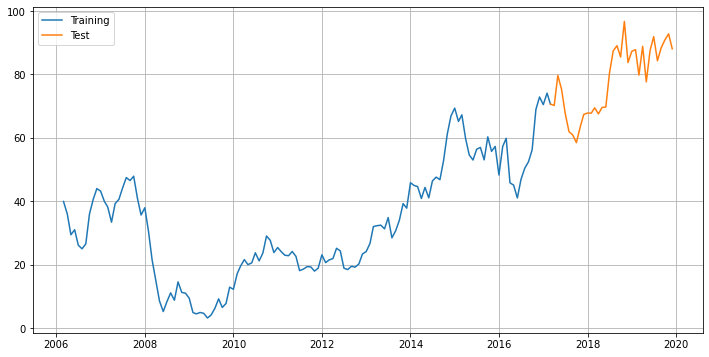

In [376]:
# Plot the training and test sets
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training')
plt.plot(test_data, label='Test')
plt.legend()
plt.grid()


ADF Statistic: -0.519058
p-value: 0.888243
All adfuller values: (-0.5190582896500043, 0.8882434357550382, 0, 132, {'1%': -3.4808880719210005, '5%': -2.8836966192225284, '10%': -2.5785857598714417}, 677.5943116394391)


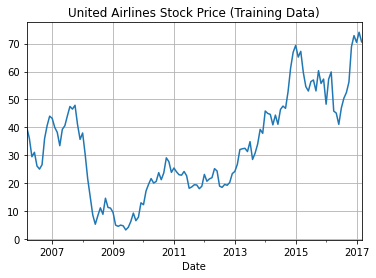

In [377]:
# Augmented Dickey-Fuller test
result = adfuller(train_data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('All adfuller values:', result)
train_data.plot(title='United Airlines Stock Price (Training Data)')
plt.grid()

Plotting PACF (Partial Autocorrelation Function) and ACF (Autocorrelation Function)

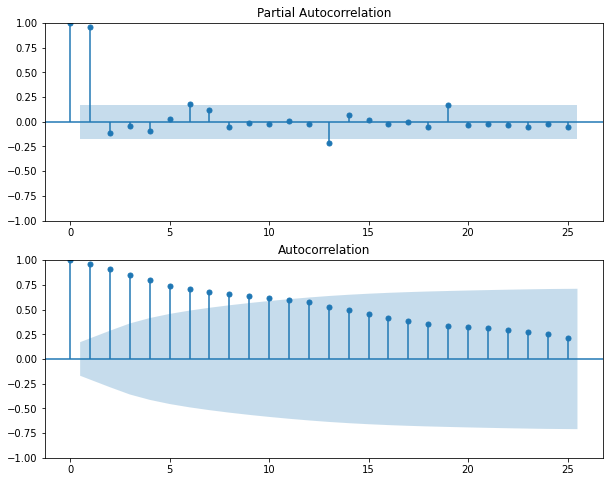

In [378]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_pacf(train_data, ax=ax1, method='ywm',lags=25)
plot_acf(train_data, ax=ax2,lags=25)
plt.show()

Differencing the data for stationarity

ADF Statistic: -5.912010
p-value: 0.000000
All adfuller values: (-5.9120098371506895, 2.6253777975098863e-07, 5, 126, {'1%': -3.4833462346078936, '5%': -2.8847655969877666, '10%': -2.5791564575459813}, 670.6357913399904)


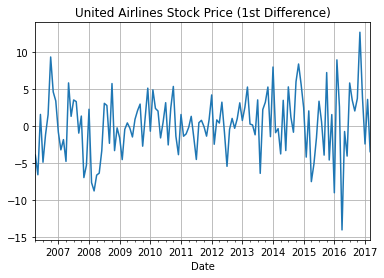

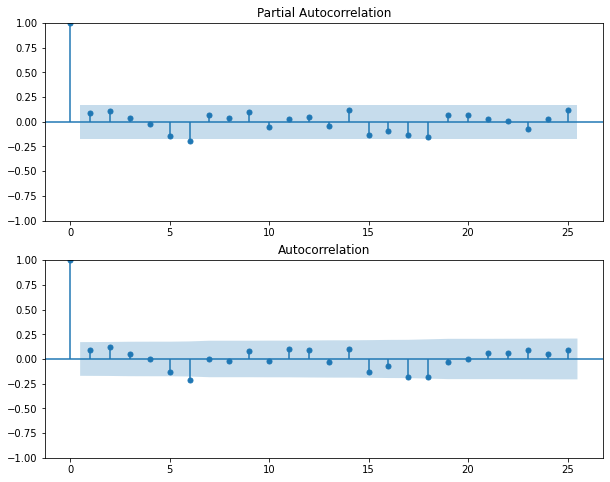

In [379]:
# Difference the data
train_data_diff = train_data.diff().dropna()
train_data_diff.plot(title='United Airlines Stock Price (1st Difference)')
plt.grid()

# Augmented Dickey-Fuller test on differenced data
result_diff = adfuller(train_data_diff)
print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])
print('All adfuller values:', result_diff)


# Plot the ACF and PACF of the differenced data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_pacf(train_data_diff, ax=ax1, method='ywm',lags=25)
plot_acf(train_data_diff, ax=ax2,lags=25)
plt.show()

ADF Statistic: -4.279906
p-value: 0.000481
All values: (-4.279905973007729, 0.0004811819845605738, 13, 117, {'1%': -3.487517288664615, '5%': -2.8865777180380032, '10%': -2.5801239192052012}, 679.7368120105433)


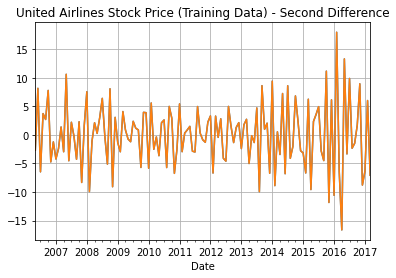

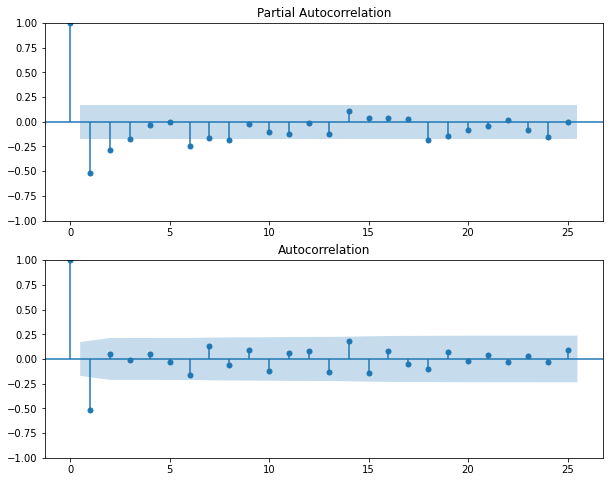

In [380]:
# Difference the data again
train_data_diff2 = train_data_diff.diff().dropna()
train_data_diff2.plot(title='United Airlines Stock Price (Training Data) - Second Difference')

# Augmented Dickey-Fuller test on second differenced data
result_diff2 = adfuller(train_data_diff2)
print('ADF Statistic: %f' % result_diff2[0])
print('p-value: %f' % result_diff2[1])
print('All values:', result_diff2)
train_data_diff2.plot(title='United Airlines Stock Price (Training Data) - Second Difference')
plt.grid()

# PACF and ACF plots on second differenced data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_pacf(train_data_diff2, ax=ax1, method='ywm',lags=25)
plot_acf(train_data_diff2, ax=ax2,lags=25)
plt.show()

In [381]:
model_fit = SARIMAX(train_data, order=(6, 1, 6), seasonal_order=(1,1,1,12)).fit()
predicted = model_fit.predict(start=train_size, end=train_size+test_size-1)
print(mean_squared_error(predicted,test_data))
model_fit.summary()

c:\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


137.14862735976783


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Close   No. Observations:                  133
Model:             SARIMAX(6, 1, 6)x(1, 1, [1], 12)   Log Likelihood                -343.570
Date:                              Sun, 23 Apr 2023   AIC                            717.141
Time:                                      07:42:45   BIC                            758.953
Sample:                                  03-01-2006   HQIC                           734.121
                                       - 03-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0956      0.768      0.125      0.901      -1.409       1.600
ar.L2         -0.0842      0.759     -0.111      0.912      -1.571       1.403
ar.L3          0.0494      0.687      0.072      0.943      -1.298       1.397
ar.L4          0.4063      0.952      0.427      0.669      -1.459       2.272
ar.L5         -0.0949      0.490     -0.194      0.846      -1.054       0.865
ar.L6          0.5612      0.609      0.921      0.357      -0.633       1.756
ma.L1         -0.1235      0.861     -0.143      0.886      -1.811       1.564
ma.L2          0.2507      0.839      0.299      0.765      -1.394       1.895
ma.L3          0.1002      0.847      0.118      0.906      -1.559       1.760
ma.L4         -0.3330      1.249     -0.267      0.790      -2.782       2.116
ma.L5         -0.0233      0.665     -0.035      0.972      -1.327       1.281
ma.L6         -0.8203      0.895     -0.916      0.360      -2.575       0.935
ar.S.L12       0.0821      0.187      0.439      0.660      -0.284       0.449
ma.S.L12      -0.8851      0.372     -2.381      0.017      -1.614      -0.156
sigma2        15.1289      4.222      3.584      0.000       6.855      23.403
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.59
Prob(Q):                              0.93   Prob(JB):                         0.75
Heteroskedasticity (H):               1.46   Skew:                            -0.15
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Looking at the forecast of the training data, we can see that the model learns quite well

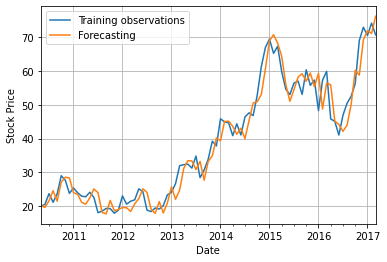

In [382]:
train_data.iloc[50:].plot(label='Training observations')
model_fit.predict(start=50, end=train_size).plot(label='Forecasting')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

Plotting training observations, forecasting test observations

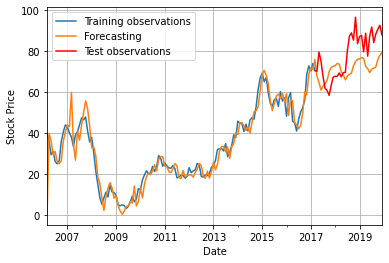

In [383]:
# Plot Training observations up until first forecasted, then plot the forecasted values, also plot the test data
train_data.iloc[:].plot(label='Training observations')
model_fit.predict(start=0, end=train_size+test_size-1).plot(label='Forecasting')
test_data.plot(label='Test observations', color='red')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

Zoomed in view of the forecast, to see how the model performs on the test data

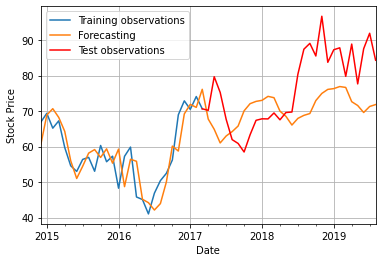

In [384]:
train_data.iloc[105:].plot(label='Training observations')
model_fit.predict(start=105, end=train_size+test_size-5).plot(label='Forecasting')
test_data.iloc[:-4].plot(label='Test observations', color='red')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

In [385]:
model_fit = SARIMAX(train_data, order=(6, 1, 3), seasonal_order=(1,1,1,12)).fit() 
predicted = model_fit.predict(start=train_size, end=train_size+test_size-1)
print(mean_squared_error(predicted,test_data))
model_fit.summary()

c:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


120.26315239478453


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Close   No. Observations:                  133
Model:             SARIMAX(6, 1, 3)x(1, 1, [1], 12)   Log Likelihood                -345.903
Date:                              Sun, 23 Apr 2023   AIC                            715.806
Time:                                      07:42:50   BIC                            749.256
Sample:                                  03-01-2006   HQIC                           729.390
                                       - 03-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7515      0.410     -1.832      0.067      -1.556       0.053
ar.L2         -0.6050      0.197     -3.064      0.002      -0.992      -0.218
ar.L3         -0.7202      0.320     -2.253      0.024      -1.347      -0.094
ar.L4          0.1912      0.173      1.106      0.269      -0.148       0.530
ar.L5          0.1011      0.171      0.592      0.554      -0.234       0.436
ar.L6         -0.0259      0.131     -0.198      0.843      -0.283       0.231
ma.L1          0.7716      0.428      1.801      0.072      -0.068       1.611
ma.L2          0.7393      0.192      3.842      0.000       0.362       1.116
ma.L3          0.9080      0.364      2.497      0.013       0.195       1.621
ar.S.L12      -0.1355      0.164     -0.826      0.409      -0.457       0.186
ma.S.L12      -0.6463      0.194     -3.337      0.001      -1.026      -0.267
sigma2        18.1322      2.777      6.530      0.000      12.690      23.575
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.73
Prob(Q):                              0.83   Prob(JB):                         0.70
Heteroskedasticity (H):               1.28   Skew:                            -0.16
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

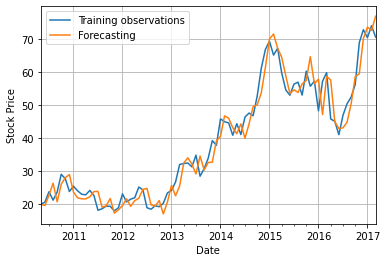

In [386]:
train_data.iloc[50:].plot(label='Training observations')
model_fit.predict(start=50, end=train_size).plot(label='Forecasting')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

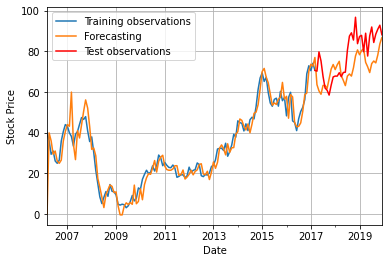

In [387]:
# Plot Training observations up until first forecasted, then plot the forecasted values, also plot the test data
train_data.iloc[:].plot(label='Training observations')
model_fit.predict(start=0, end=train_size+test_size-1).plot(label='Forecasting')
test_data.plot(label='Test observations', color='red')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

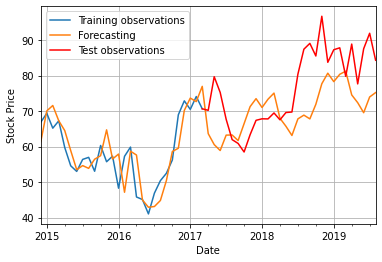

In [388]:
train_data.iloc[105:].plot(label='Training observations')
model_fit.predict(start=105, end=train_size+test_size-5).plot(label='Forecasting')
test_data.iloc[:-4].plot(label='Test observations', color='red')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

In [389]:
model_fit = ARIMA(train_data, order=(6, 1, 6)).fit() # (p, d, q)
predicted = model_fit.predict(start=train_size, end=train_size+test_size-1)
print(mean_squared_error(predicted,test_data))
model_fit.summary()

c:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


221.8064394354824


c:\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  133
Model:                 ARIMA(6, 1, 6)   Log Likelihood                -362.258
Date:                Sun, 23 Apr 2023   AIC                            750.516
Time:                        07:42:52   BIC                            787.993
Sample:                    03-01-2006   HQIC                           765.745
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1652      0.602      0.274      0.784      -1.015       1.345
ar.L2          0.2631      0.449      0.586      0.558      -0.617       1.143
ar.L3         -0.4274      0.376     -1.136      0.256      -1.165       0.310
ar.L4         -0.1830      0.263     -0.695      0.487      -0.699       0.333
ar.L5          0.5646      0.316      1.786      0.074      -0.055       1.184
ar.L6         -0.3546      0.361     -0.982      0.326      -1.063       0.353
ma.L1         -0.1575      0.657     -0.240      0.811      -1.446       1.131
ma.L2         -0.0433      0.470     -0.092      0.927      -0.965       0.879
ma.L3          0.5418      0.353      1.534      0.125      -0.150       1.234
ma.L4          0.2276      0.437      0.521      0.602      -0.628       1.084
ma.L5         -0.7275      0.489     -1.488      0.137      -1.685       0.230
ma.L6          0.2468      0.551      0.448      0.654      -0.833       1.327
sigma2        13.7833      2.479      5.560      0.000       8.925      18.642
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 3.76
Prob(Q):                              0.61   Prob(JB):                         0.15
Heteroskedasticity (H):               1.70   Skew:                            -0.27
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

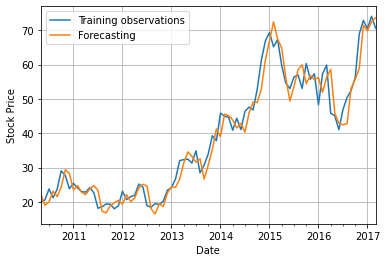

In [390]:
train_data.iloc[50:].plot(label='Training observations')
model_fit.predict(start=50, end=train_size).plot(label='Forecasting')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

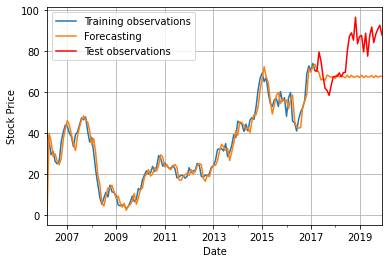

In [391]:
# Plot Training observations up until first forecasted, then plot the forecasted values, also plot the test data
train_data.iloc[:].plot(label='Training observations')
model_fit.predict(start=0, end=train_size+test_size-1).plot(label='Forecasting')
test_data.plot(label='Test observations', color='red')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()